# Q3
Generating the datasets. All images I created contains 2-5 instances of the letters I and T and rest are random dots spread over the canvas.
I have created 4 datasets with increasing level of difficulty in counting the letters by varying the spacing between the letter dots and random dot density

Dataset generation completed successfully!


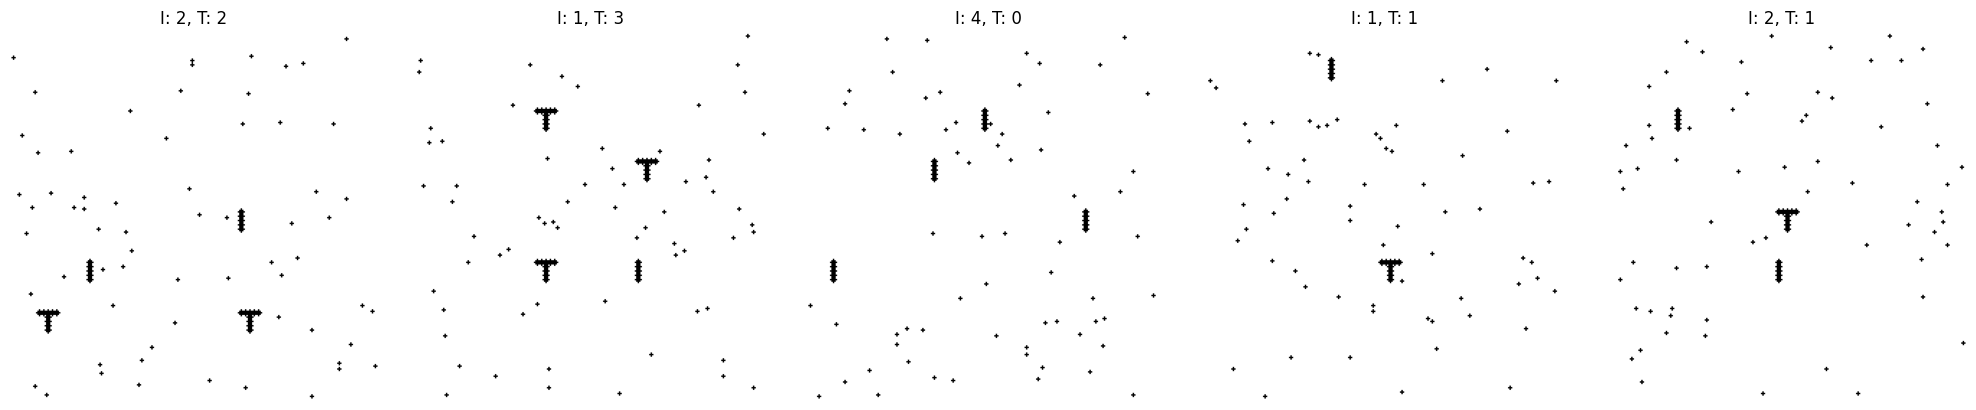

In [15]:
import cv2
import numpy as np
import pandas as pd
import os
from pathlib import Path
from typing import Tuple, List, Dict, Set
import random
import matplotlib.pyplot as plt
from dataclasses import dataclass

@dataclass
class DatasetConfig:
    """Configuration parameters for dataset generation."""
    dataset_name: str = "letters_dataset"
    letter_size: int = 2  # Reduced from 5 to 2
    spacing_between_circles: int = 5  # Reduced from 15 to 8
    random_dot_density: float = 0.1
    image_size: int = 128
    num_samples: int = 1000
    train_ratio: float = 0.8
    padding: int = 8  # Reduced from 10 to 8
    min_letters: int = 2
    max_letters: int = 5

    def __post_init__(self):
        # Calculate the space needed for letters
        self.letter_width_T = 5 * self.spacing_between_circles  # T needs 5 circles horizontally
        self.letter_height_T = 5 * self.spacing_between_circles  # T needs 5 circles vertically
        self.letter_width_I = self.spacing_between_circles  # I needs 1 circle horizontally
        self.letter_height_I = 5 * self.spacing_between_circles  # I needs 5 circles vertically

        # Calculate cell size based on the larger letter (T)
        self.cell_size = max(self.letter_width_T, self.letter_height_T) + self.padding

        # Validate configuration
        max_letters_possible = ((self.image_size - self.padding * 2) // self.cell_size) ** 2
        if max_letters_possible < self.max_letters:
            raise ValueError(f"Image size too small for {self.max_letters} letters. Maximum possible: {max_letters_possible}")

class LetterDrawer:
    """Handles drawing of letters in images."""

    def __init__(self, image_size: int, letter_size: int):
        self.image_size = image_size
        self.letter_size = letter_size

    def _is_valid_position(self, x: int, y: int) -> bool:
        """Check if position is within image bounds."""
        return 0 <= x < self.image_size and 0 <= y < self.image_size

    def draw_I(self, image: np.ndarray, x: int, y: int, gap: int) -> Set[Tuple[int, int]]:
        """
        Draws the letter 'I' with circles and returns the set of occupied positions.
        """
        occupied_positions = set()
        for i in range(5):
            center_y = y + i * gap
            if self._is_valid_position(x, center_y):
                cv2.circle(image, (x, center_y), self.letter_size, (0, 0, 0), -1)
                # Add positions covered by the circle
                for dy in range(-self.letter_size, self.letter_size + 1):
                    for dx in range(-self.letter_size, self.letter_size + 1):
                        occupied_positions.add((x + dx, center_y + dy))
        return occupied_positions

    def draw_T(self, image: np.ndarray, x: int, y: int, gap: int) -> Set[Tuple[int, int]]:
        """
        Draws the letter 'T' with circles and returns the set of occupied positions.
        """
        occupied_positions = set()

        # Draw horizontal line of T (centered)
        center_x_base = x + 2 * gap
        for i in range(-2, 3):  # 5 circles for horizontal line, centered
            center_x = x + (i + 2) * gap
            if self._is_valid_position(center_x, y):
                cv2.circle(image, (center_x, y), self.letter_size, (0, 0, 0), -1)
                # Add positions covered by the circle
                for dy in range(-self.letter_size, self.letter_size + 1):
                    for dx in range(-self.letter_size, self.letter_size + 1):
                        occupied_positions.add((center_x + dx, y + dy))

        # Draw vertical line of T
        for j in range(1, 5):  # 4 more circles for vertical line (excluding intersection)
            center_y = y + j * gap
            if self._is_valid_position(center_x_base, center_y):
                cv2.circle(image, (center_x_base, center_y), self.letter_size, (0, 0, 0), -1)
                # Add positions covered by the circle
                for dy in range(-self.letter_size, self.letter_size + 1):
                    for dx in range(-self.letter_size, self.letter_size + 1):
                        occupied_positions.add((center_x_base + dx, center_y + dy))

        return occupied_positions

class ImageGenerator:
    """Handles generation of images with letters and noise."""

    def __init__(self, config: DatasetConfig):
        self.config = config
        self.letter_drawer = LetterDrawer(config.image_size, config.letter_size)

    def scatter_random_dots(self, image: np.ndarray, occupied_positions: Set[Tuple[int, int]]) -> None:
        """Adds random noise dots to the image, avoiding letter positions."""
        num_dots = int(self.config.random_dot_density * self.config.image_size * self.config.image_size)

        dots_placed = 0
        max_attempts = num_dots * 4  # Limit attempts to avoid infinite loops
        attempts = 0

        while dots_placed < num_dots and attempts < max_attempts:
            x = random.randint(2, self.config.image_size - 3)
            y = random.randint(2, self.config.image_size - 3)

            # Check if position is occupied by a letter
            position_free = True
            for dx in range(-1, 2):
                for dy in range(-1, 2):
                    if (x + dx, y + dy) in occupied_positions:
                        position_free = False
                        break
                if not position_free:
                    break

            if position_free and np.all(image[y-1:y+2, x-1:x+2] == 255):
                cv2.circle(image, (x, y), 1, (0, 0, 0), -1)
                dots_placed += 1

            attempts += 1

    def generate_grid_positions(self) -> List[Tuple[int, int]]:
        """Generates possible non-overlapping positions for letters."""
        positions = []
        for i in range(self.config.padding,
                      self.config.image_size - self.config.padding - self.config.cell_size,
                      self.config.cell_size):
            for j in range(self.config.padding,
                         self.config.image_size - self.config.padding - self.config.cell_size,
                         self.config.cell_size):
                positions.append((i, j))

        random.shuffle(positions)
        return positions

    def generate_single_image(self) -> Tuple[np.ndarray, Dict[str, int]]:
        """Generates a single image with letters and returns the image and letter counts."""
        img = np.ones((self.config.image_size, self.config.image_size, 3), dtype=np.uint8) * 255
        grid_positions = self.generate_grid_positions()
        letter_counts = {'I': 0, 'T': 0}
        occupied_positions = set()

        total_letters = random.randint(self.config.min_letters,
                                     min(self.config.max_letters, len(grid_positions)))

        for _ in range(total_letters):
            if not grid_positions:
                break

            x, y = grid_positions.pop()
            letter_type = random.choice(['I', 'T'])

            new_occupied = set()
            if letter_type == 'I':
                new_occupied = self.letter_drawer.draw_I(img, x, y, self.config.spacing_between_circles)
                letter_counts['I'] += 1
            else:
                new_occupied = self.letter_drawer.draw_T(img, x, y, self.config.spacing_between_circles)
                letter_counts['T'] += 1

            occupied_positions.update(new_occupied)

        self.scatter_random_dots(img, occupied_positions)
        return img, letter_counts


class DatasetGenerator:
    """Manages the generation and saving of the complete dataset."""

    def __init__(self, config: DatasetConfig):
        self.config = config
        self.image_generator = ImageGenerator(config)

    def setup_directories(self) -> Tuple[Path, Path]:
        """Creates and returns paths for train and test directories."""
        output_dir = Path(self.config.dataset_name)
        train_dir = output_dir / "train"
        test_dir = output_dir / "test"

        train_dir.mkdir(parents=True, exist_ok=True)
        test_dir.mkdir(parents=True, exist_ok=True)

        return train_dir, test_dir

    def generate_dataset(self) -> Tuple[Path, Path]:
        """Generates complete dataset with training and testing splits."""
        train_dir, test_dir = self.setup_directories()
        num_train = int(self.config.num_samples * self.config.train_ratio)

        self._generate_split(train_dir, num_train, "training")
        self._generate_split(test_dir, self.config.num_samples - num_train, "testing")

        return train_dir, test_dir

    def _generate_split(self, output_dir: Path, num_samples: int, split_name: str) -> None:
        """Generates and saves images and labels for a dataset split."""
        csv_data = []

        for i in range(num_samples):
            img, letter_counts = self.image_generator.generate_single_image()
            filename = f"img_{i:05d}.png"
            cv2.imwrite(str(output_dir / filename), img)

            csv_data.append([filename, letter_counts['I'], letter_counts['T']])

            if (i + 1) % 100 == 0:
                print(f"Generated {i + 1}/{num_samples} {split_name} images")

        # Save labels
        df = pd.DataFrame(csv_data, columns=["filename", "num_I", "num_T"])
        df.to_csv(output_dir / "labels.csv", index=False)

def display_sample_images(dataset_dir: Path, num_samples: int = 5) -> None:
    """Displays random samples from the specified dataset directory."""
    labels = pd.read_csv(dataset_dir / "labels.csv")
    samples = labels.sample(n=min(num_samples, len(labels)))

    fig, axes = plt.subplots(1, len(samples), figsize=(4 * len(samples), 4))
    if len(samples) == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, samples.iterrows()):
        img = cv2.imread(str(dataset_dir / row['filename']))
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(f"I: {row['num_I']}, T: {row['num_T']}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Usage Example
if __name__ == "__main__":
    config = DatasetConfig(
        dataset_name="letter_dataset",
        letter_size=2,
        spacing_between_circles=3,
        random_dot_density=0.001,
        image_size=256,
        num_samples=100,
        min_letters=2,
        max_letters=5,
        train_ratio=0.8,
        padding=20,
    )

    try:
        generator = DatasetGenerator(config)
        train_dir, test_dir = generator.generate_dataset()
        print("Dataset generation completed successfully!")

        # Display sample images from the training dataset
        display_sample_images(train_dir, num_samples=5)

    except Exception as e:
        print(f"Error generating dataset: {str(e)}")

Dataset generation completed successfully!


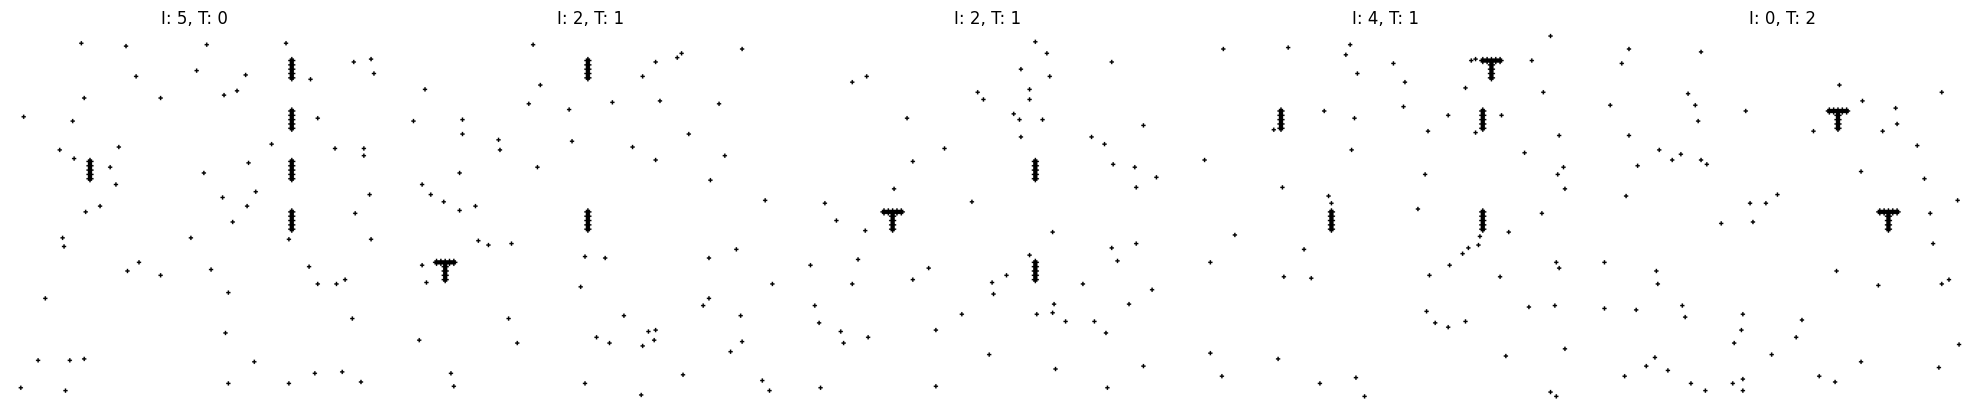

In [73]:
config = DatasetConfig(
        dataset_name="dataset_1",
        letter_size=2,
        spacing_between_circles=3,
        random_dot_density=0.001,
        image_size=256,
        num_samples=100,
        min_letters=2,
        max_letters=5,
        train_ratio=0.8,
        padding=20,
    )
try:
        generator = DatasetGenerator(config)
        train1_dir, test1_dir = generator.generate_dataset()
        print("Dataset generation completed successfully!")

        # Display sample images from the training dataset
        display_sample_images(train1_dir, num_samples=5)

except Exception as e:
        print(f"Error generating dataset: {str(e)}")

Dataset generation completed successfully!


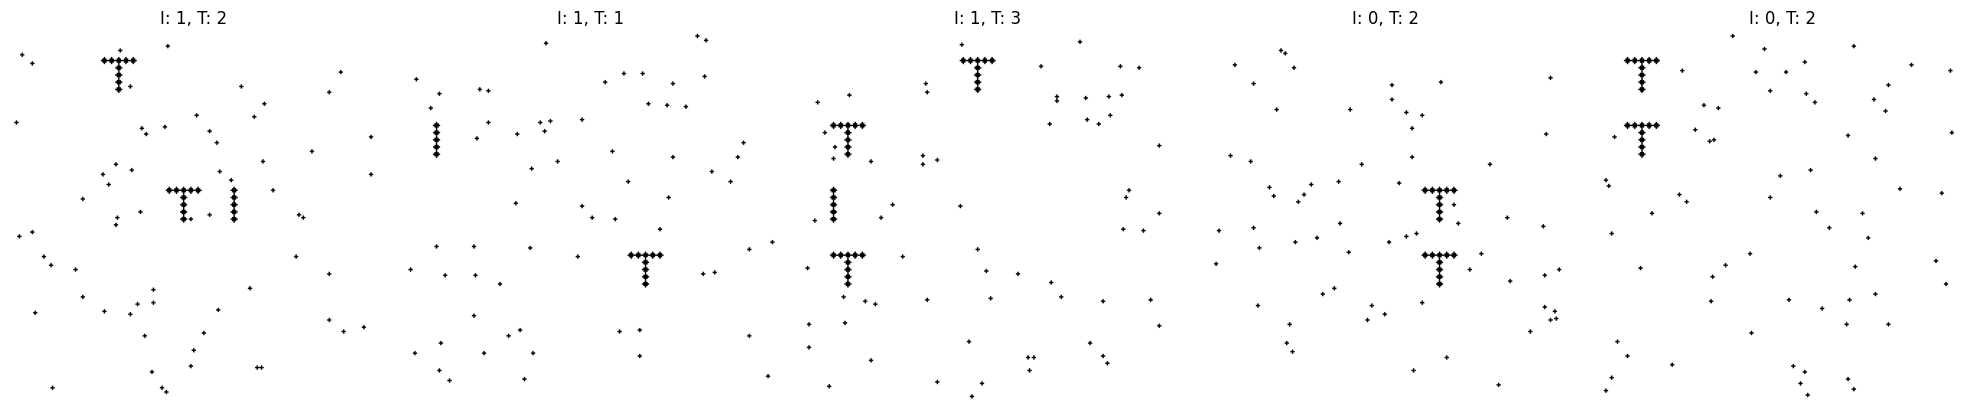

In [57]:
config = DatasetConfig(
        dataset_name="dataset_2",
        letter_size=2,
        spacing_between_circles=5,
        random_dot_density=0.001,
        image_size=256,
        num_samples=100,
        min_letters=2,
        max_letters=6,
        train_ratio=0.8,
        padding=20,
    )
try:
        generator = DatasetGenerator(config)
        train2_dir, test2_dir = generator.generate_dataset()
        print("Dataset generation completed successfully!")

        # Display sample images from the training dataset
        display_sample_images(train2_dir, num_samples=5)

except Exception as e:
        print(f"Error generating dataset: {str(e)}")

Dataset generation completed successfully!


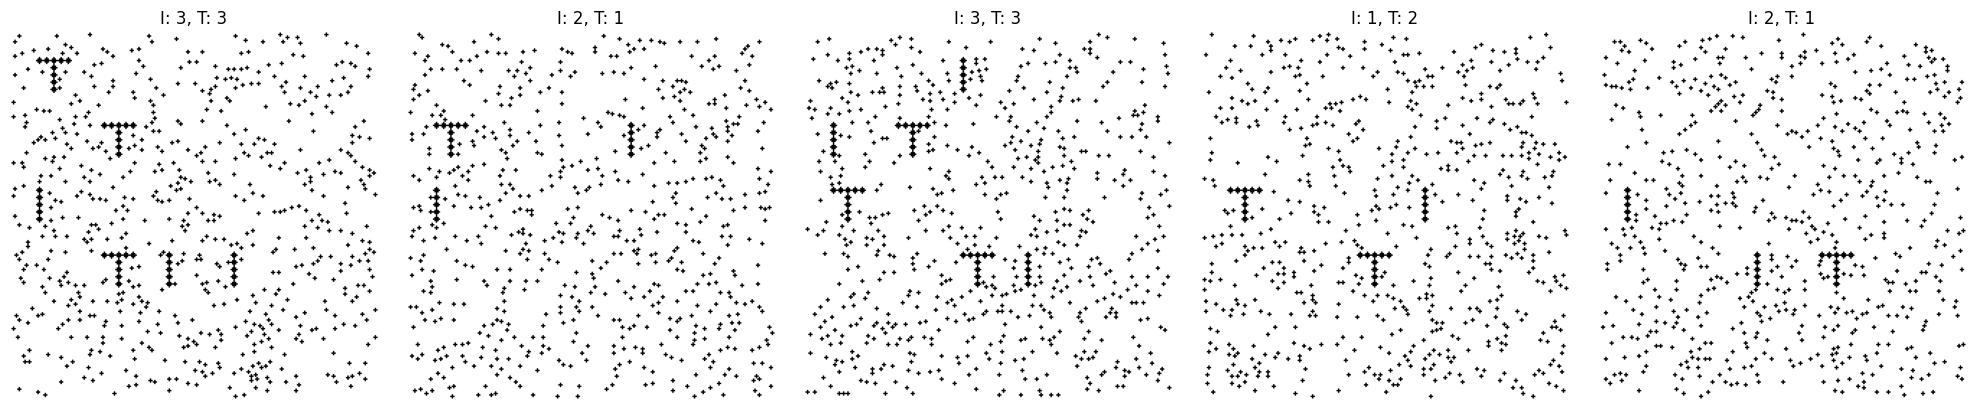

In [58]:
config = DatasetConfig(
        dataset_name="dataset_3",
        letter_size=2,
        spacing_between_circles=5,
        random_dot_density=0.01,
        image_size=256,
        num_samples=100,
        min_letters=2,
        max_letters=6,
        train_ratio=0.8,
        padding=20,
    )
try:
        generator = DatasetGenerator(config)
        train3_dir, test3_dir = generator.generate_dataset()
        print("Dataset generation completed successfully!")

        # Display sample images from the training dataset
        display_sample_images(train3_dir, num_samples=5)

except Exception as e:
        print(f"Error generating dataset: {str(e)}")

the following dataset would be the most difficult to learn for the model.

Dataset generation completed successfully!


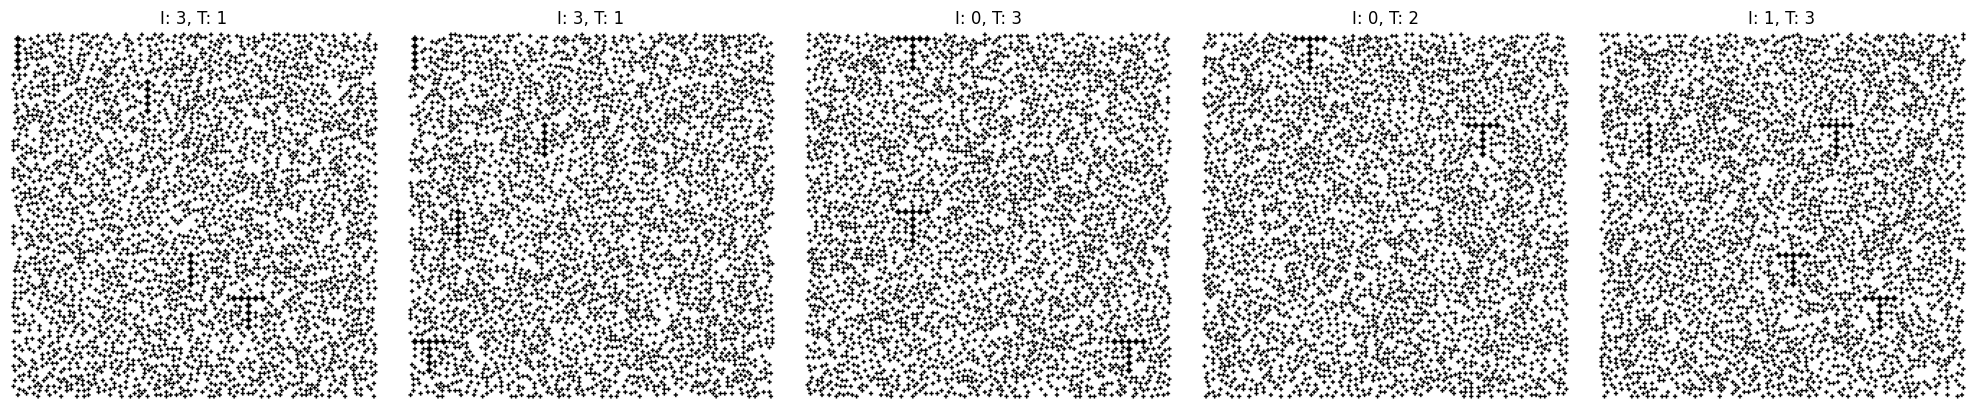

In [59]:
config = DatasetConfig(
        dataset_name="dataset_4",
        letter_size=2,
        spacing_between_circles=5,
        random_dot_density=0.05,
        image_size=256,
        num_samples=100,
        min_letters=2,
        max_letters=5,
        train_ratio=0.8,
        padding=5,
    )
try:
        generator = DatasetGenerator(config)
        train4_dir, test4_dir = generator.generate_dataset()
        print("Dataset generation completed successfully!")

        # Display sample images from the training dataset
        display_sample_images(train4_dir, num_samples=5)

except Exception as e:
        print(f"Error generating dataset: {str(e)}")

In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

# Define the custom dataset class for your data
class LetterDataset(Dataset):
    def __init__(self, folder, csv_file, transform=None):
        self.folder = folder
        self.labels = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        row = self.labels.iloc[index]
        image_file = os.path.join(self.folder, row['filename'])
        image = Image.open(image_file).convert('L')  # Convert image to grayscale
        label = 0 if row['num_I'] > 0 else 1  # Label as 0 for 'I', 1 for 'T'

        if self.transform:
            image = self.transform(image)

        return image, label

# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):  # 2 classes for 'I' and 'T'
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Updated input size for fc1 based on the flattened size
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))  # First conv + activation + pooling
        x = self.pool(nn.ReLU()(self.conv2(x)))  # Second conv + activation + pooling

        print(x.shape)  # Debugging: Check shape after pooling

        x = x.view(x.size(0), -1)  # Flatten tensor
        x = nn.ReLU()(self.fc1(x))  # Fully connected layer + activation
        x = self.fc2(x)  # Output layer

        return x


# Setup for device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=2).to(device)

# Define the transformations
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load the datasets using your CSV labels
train_dataset = LetterDataset('dataset_1/train', 'dataset_1/train/labels.csv', transform=image_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

test_dataset = LetterDataset('dataset_1/test', 'dataset_1/test/labels.csv', transform=image_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the CNN model
def train_model(model, data_loader, loss_fn, optimizer, epochs=10):
    model.train()
    for images, labels in data_loader:
      print(f"Images: {images.shape}, Labels: {labels.shape}")
      break  # Check one batch to confirm shapes are correct


    for epoch in range(epochs):
        running_loss = 0.0
        correct_preds = 0
        total_samples = 0

        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            running_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_preds += (predictions == labels).sum().item()

        accuracy = 100 * correct_preds / total_samples
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(data_loader):.4f}, Accuracy: {accuracy:.2f}%")

# Train the model
train_model(model, train_loader, loss_function, optimizer)

# Test the model
def test_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

# Evaluate on test data
test_model(model, test_loader)


Images: torch.Size([32, 1, 128, 128]), Labels: torch.Size([32])
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [1/10], Loss: 0.9488, Accuracy: 82.81%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [2/10], Loss: 1.0035, Accuracy: 82.81%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [3/10], Loss: 0.5779, Accuracy: 81.25%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [4/10], Loss: 0.6319, Accuracy: 81.25%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [5/10], Loss: 0.5738, Accuracy: 82.81%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [6/10], Loss: 0.4608, Accuracy: 84.38%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [7/10], Loss: 0.3087, Accuracy: 90.62%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [8/10], Loss: 0.4571, Accuracy: 84.38%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [9/10], Loss: 0.4203, Accuracy: 84.38%
torch.Siz

In [93]:
# List of dataset paths
datasets = [
    ("dataset_1", "dataset_1/train/labels.csv", "dataset_1/test/labels.csv"),
    ("dataset_2", "dataset_2/train/labels.csv", "dataset_2/test/labels.csv"),
    ("dataset_3", "dataset_3/train/labels.csv", "dataset_3/test/labels.csv"),
    ("dataset_4", "dataset_4/train/labels.csv", "dataset_4/test/labels.csv"),
]

# Loop through each dataset and train/test the model
for dataset_name, train_csv, test_csv in datasets:
    print(f"\nTraining and Testing on {dataset_name}")

    # Load the datasets using your CSV labels
    train_dataset = LetterDataset(f'{dataset_name}/train', train_csv, transform=image_transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

    test_dataset = LetterDataset(f'{dataset_name}/test', test_csv, transform=image_transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Reinitialize the model and optimizer for each dataset
    model = SimpleCNN(num_classes=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    print(f"Training on {dataset_name}")
    train_model(model, train_loader, loss_function, optimizer)

    # Test the model
    print(f"Testing on {dataset_name}")
    test_model(model, test_loader)



Training and Testing on dataset_1
Training on dataset_1
Images: torch.Size([32, 1, 128, 128]), Labels: torch.Size([32])
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [1/10], Loss: 1.4490, Accuracy: 85.94%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [2/10], Loss: 1.9922, Accuracy: 84.38%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [3/10], Loss: 0.6767, Accuracy: 46.88%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [4/10], Loss: 0.5503, Accuracy: 87.50%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [5/10], Loss: 0.4932, Accuracy: 81.25%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [6/10], Loss: 0.5024, Accuracy: 81.25%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [7/10], Loss: 0.4935, Accuracy: 81.25%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [8/10], Loss: 0.4274, Accuracy: 85.94%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32

as expected, the model performs well when the random dot density is low and the accuracy drops with the increase in density and spacing which is logical.